<img src="../imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## 3.2 NSGA-II

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

## Outline

1. [The Knapsack Problem](#knapsack)
2. [Evolution](#evolution)
3. [Visualization](#visualization)

In [16]:
using NSGAII
using JuMP, GLPK
using Plots
default(show=:ijulia)

┌ Info: Precompiling GLPK [60bf3e95-4087-53dc-ae20-288a0d20c6a6]
└ @ Base loading.jl:1260


To experiment with NSGAII we'll be using a rather new implementation of it from Github: https://github.com/gsoleilhac/NSGAII.jl/.

This implementation isn't so complicated and if we look at the code, we can see that much of it resembles our [notebook code](https://github.com/d9w/evolution/blob/master/2_ga/1_GAs.ipynb) on Genetic Algorithms. Let's look at the [functions](https://github.com/gsoleilhac/NSGAII.jl/blob/master/src/functions.jl) code which contains the main Genetic Algorithm loop, as well as the [NSGA-II](http://repository.ias.ac.in/83498/1/2-a.pdf) Fast Non-Dominated Sort and Crowding Distance Algorithm.

## <a id="knapsack"></a>The Knapsack Problem

<img src="https://imgs.xkcd.com/comics/np_complete.png">
<div style="text-align:center"><a href="https://xkcd.com/287/">XKCD on the Knapsack Problem</a></div>


Imagine we're travelling and our bag has a maximum weight limit. We want to fill this bag with items of different value and maximize the total value in our bag, as long as it stays in the weight limit. This is known as the "knapsack problem".
<img src="../imgs/knapsack.png" width="30%" height="auto">
Instead of a bag with items, you could imagine a scenario like the comic. You want to order different appetizers, but you only want to spend a fixed maximum amount. How can you get the best appetizers?

Let's look at an example, specifically using the version of the Knapsack problem known as the "0-1 knapsack problem" where we can have at most 1 copy of each item. We'll use 5 items and randomly geneate values for them.

In [5]:
n = 5
values = rand(0:100, n)
println(values, " total value: ", sum(values))

[78, 20, 46, 80, 6] total value: 230


In [6]:
weights = rand(10:20, n)
max_weight = 55
println(weights, " total weight: ", sum(weights))

[10, 20, 19, 16, 17] total weight: 82


We won't be able to take all items because of the maximum weight of 55. We'll express our choice of items using a binary string, 1 if we take the item and 0 otherwise.

In [8]:
using Random: bitrand
choices = bitrand(n)
println(choices)

Bool[1, 1, 1, 0, 0]


The total value of our knapsack is therefore the sum of the element-wise multiplication of our choices and the individual item values.

In [9]:
sum(choices .* values)

144

In other words, the dot product of the two vectors.

In [10]:
using LinearAlgebra: dot
dot(choices, values)

144

We can also use the dot product to check if our choices fall under the weight limit

In [11]:
dot(choices, weights), max_weight

(49, 55)

Let's say you and a friend are travelling together and to make it cheaper, you're sharing a bag. You and your friend assign different values to each item based on what you want to bring on the trip. Your preferences are in `values` and your friends preferences are:

In [13]:
values2 = rand(0:100, n)
println("You:\t", values, " total value: ", sum(values))
println("Friend:\t", values2, " total value: ", sum(values2))

You:	[78, 20, 46, 80, 6] total value: 230
Friend:	[89, 86, 2, 0, 85] total value: 262


Let's see who is happier with the choices we made

In [14]:
choices = bitrand(n)
println(choices)
println("weight: ", dot(choices, weights))
println("You: ", dot(choices, values), " Friend: ", dot(choices, values2))

Bool[0, 1, 0, 1, 1]
weight: 53
You: 106 Friend: 171


This is the multi-objective version of the Knapsack problem where we use $K$ different value vectors for $K$ objectives.

[The Knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem) has been thoroughly studied in theoretical computer science and evolutionary computation is not the only choice for solving it; dynamic programming and mixed integer programming are what [JuMP](https://github.com/JuliaOpt/JuMP.jl), an optimization library, uses.

In [23]:
# Note that this uses JuMP 0.18.6 format, different in JuMP 0.19
m = Model(GLPK.Optimizer)
@variable(m, x[1:n], Bin)
# Objective: maximize profit
@objective(m, Max, dot(values, x))
@objective(m, Max, dot(values2, x))
# Constraint: can carry all
@constraint(m, dot(weights, x) <= max_weight)
# Solve problem using MIP solver
status = optimize!(m);

In [26]:
println("Objective is: ", objective_value(m))
println("Solution is:")
for i = 1:5
    print("x[$i] = ", value(x[i]))
    print(", p[$i]/w[$i] = ", values[i]/weights[i])
    println(", p[$i]/w[$i] = ", values2[i]/weights[i])
end

Objective is: 260.0
Solution is:
x[1] = 1.0, p[1]/w[1] = 7.8, p[1]/w[1] = 8.9
x[2] = 1.0, p[2]/w[2] = 1.0, p[2]/w[2] = 4.3
x[3] = 0.0, p[3]/w[3] = 2.4210526315789473, p[3]/w[3] = 0.10526315789473684
x[4] = 0.0, p[4]/w[4] = 5.0, p[4]/w[4] = 0.0
x[5] = 1.0, p[5]/w[5] = 0.35294117647058826, p[5]/w[5] = 5.0


## <a id="evolution"></a>Evolution

To apply NSGA-II to this problem, let's scale up the number of items to 100. 

In [36]:
n = 100
n_objectives = 2
values = rand(n, n_objectives)

100×2 Array{Float64,2}:
 0.0978855  0.580848
 0.75104    0.398485
 0.709383   0.746274
 0.989419   0.950773
 0.0250212  0.468426
 0.319331   0.26357
 0.796687   0.544318
 0.787066   0.436058
 0.33712    0.2165
 0.0620432  0.26118
 0.363938   0.670993
 0.467738   0.841982
 0.205421   0.422943
 ⋮          
 0.685064   0.715374
 0.683157   0.565694
 0.106115   0.934941
 0.388355   0.956949
 0.363471   0.425992
 0.740436   0.321348
 0.381911   0.218055
 0.278892   0.12364
 0.571229   0.488896
 0.256692   0.0519284
 0.989943   0.86601
 0.182203   0.192367

Let's normalize our fitness values by their sum, so that the total maximum value is 1.0 which will help with plotting later.

In [37]:
values = values ./ sum(values, dims=1);
sum(values, dims=1)

1×2 Array{Float64,2}:
 1.0  1.0

Similarly, let's normalize the weights to sum to 1 and set a maximum weight of 0.5, meaning we can keep only half the items on average. This will let us change the number of items more easily later on but doesn't impact the problem in any way.

In [38]:
weights = rand(n)
weights = weights ./ sum(weights)
max_weight = 0.5

0.5

Let's write our objective function which will compute the value of our knapsack using each different column of profit values.

In [39]:
function objective(genes::AbstractArray)
    fits = zeros(n_objectives)
    for i in 1:n_objectives
        fits[i] = dot(genes, values[:, i])
    end
    tuple(fits...)
end

objective (generic function with 1 method)

We'll add in our weight constraint separately. This is used in the evaluation of individuals and is considered a part of our objective function, but is handled separately. Our lecture on evolution with constraints will go into more detail on that. For this NSGA-II implementation, we return 0 if the condition passes and the distance from meeting the condition otherwise.

In [40]:
function constraint(genes::AbstractArray)
    sum_weights = dot(genes, weights)
    return sum_weights <= max_weight ? 0 : sum_weights - max_weight
end

constraint (generic function with 1 method)

That's all, so now we're ready to run NSGA-II. Let's run it for 100 generations on a population of 100. The function returns the set of non-dominated individuals at the end

In [41]:
popsize = 100
nbgen = 100
init() = bitrand(n)
non_dominated =  nsga_max(popsize, nbgen, objective, init, fCV=constraint)
non_dominated[1]

indiv([011101101011111...110111110011011] : (0.7299193725918086, 0.7437624840673543) | rank : 1)

Let's see what type of total profit values we have from our two objectives.

In [42]:
unique([collect(i.y) for i in non_dominated])

6-element Array{Array{Float64,1},1}:
 [0.7299193725918086, 0.7437624840673543]
 [0.7836875778873893, 0.6952493278207652]
 [0.7808812709267277, 0.7267389839575764]
 [0.7692459369184967, 0.7328168826445219]
 [0.7551180354604541, 0.7365532716562938]
 [0.7440472740498514, 0.7400260950555826]

Finally, we can compare this value to a value obtained by JuMP

In [44]:
m = Model(GLPK.Optimizer)
@variable(m, x[1:n], Bin)
# Objective: maximize profit
@objective(m, Max, dot(values[:,1], x))
@objective(m, Max, dot(values[:,2], x))
# Constraint: can carry all
@constraint(m, dot(weights, x) <= max_weight)
# Solve problem using MIP solver
JuMP.optimize!(m);
println("Objective is: ", JuMP.objective_value(m))
println("Solution is:")
for i in 1:5
    print("x[$i] = ", JuMP.value(x[i]))
    println(", p[$i]/w[$i] = ", values[i] / weights[i])
end

Objective is: 0.8204087212817961
Solution is:
x[1] = 0.0, p[1]/w[1] = 0.11589739588993583
x[2] = 0.0, p[2]/w[2] = 1.2128028032384535
x[3] = 1.0, p[3]/w[3] = 1.135659585143865
x[4] = 1.0, p[4]/w[4] = 15.659992528512245
x[5] = 0.0, p[5]/w[5] = 0.030582773029554037


<div class="alert alert-success">
    <b>Exercise 2</b>
    <br/>
    Increase the problem difficulty by increasing the number of items and reducing the weight limit. How does NSGA-II do?
    <br/>

</div>

In [67]:
max_weight=0.5
n=1000
values = rand(n, n_objectives)
values = values ./ sum(values, dims=1)
sum(values, dims=1)
weights = rand(n)
weights = weights ./ sum(weights)

popsize = 100
nbgen = 100
init() = bitrand(n)
non_dominated =  nsga_max(popsize, nbgen, objective, init, fCV=constraint)
unique([collect(i.y) for i in non_dominated])


5-element Array{Array{Float64,1},1}:
 [0.5932687113286341, 0.5947359465178823]
 [0.5927487894870899, 0.596816378687713]
 [0.5868623310786745, 0.5972712581761909]
 [0.5940229195890239, 0.5945163360613398]
 [0.5941582731523768, 0.5943767617745457]

## <a id="visualization"></a>Visualization

To better understand NSGA-II's evolution, let's observe the population over time.

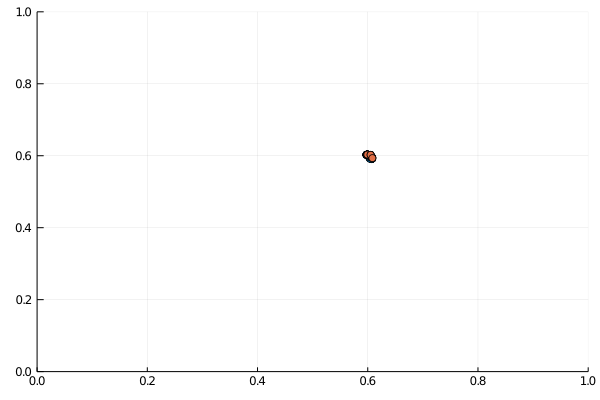

In [68]:
function plot_pop(P)
    scatter([i.y[1] for i in P], [i.y[2] for i in P], xlims=(0.0, 1.0), ylims=(0.0, 1.0), legend=:none)
    ND = filter(indiv -> indiv.rank == 1, P)
    scatter!([i.y[1] for i in ND], [i.y[2] for i in ND], legend=:none)
end

nsga_max(popsize, nbgen, objective, init, fCV=constraint, fplot=plot_pop, plotevery=1, showprogress=false);

<div class="text-info bg-info">
    On peut observer que en augmentant le nombre d'item, le front de Paredo a tendance à se focaliser sur un point particulier. On pert alors en diversité.<br/>
    Ensuite, lorsqu'on dimunue le poids maximal, la population est d'abord bloqué dans un endroit, puis se déplase brutalement à un autre endroit une fois, qu'un individu valide la contrainte. Ensuite la population suit le même cours que précédemment.
</div>

This type of visualization, plotting one objective function as X and another as Y, allows us to see the Pareto front for 2 dimensions easily. However, once we increase the number of objectives, this plot is much less useful as we'll always be constrained to looking at 2 dimensions, or at best 3.

<div class="alert alert-success">
    <b>Exercise 3</b>
    <br/>
    Change the number of objectives to 3. Then use a <tt>scatter3d</tt> plot instead of a <tt>scatter</tt> plot to plot the evolution over 3 objectives.
    <br/>
    <ul>
        <li>Can you still observe the Pareto front?</li>
        <li>Can you identify non-dominated individuals easily</li>
        <li>Do you see the performance for each objective</li>
    </ul>
    <br/>
</div>

In [72]:
max_weight = 0.4
n_objectives = 3
n = 100

values = rand(n, n_objectives)
values = values ./ sum(values, dims=1)
sum(values, dims=1)
weights = rand(n)
weights = weights ./ sum(weights)

popsize = 100
nbgen = 100
init() = bitrand(n)
non_dominated =  nsga_max(popsize, nbgen, objective, init, fCV=constraint)
unique([collect(i.y) for i in non_dominated])

34-element Array{Array{Float64,1},1}:
 [0.6315897920637056, 0.6250774898297389, 0.5806418307769301]
 [0.6357509185609832, 0.6011561604067707, 0.5541239298748458]
 [0.6049829976814749, 0.6196619835340308, 0.613853769255249]
 [0.6069621194686434, 0.6292056959456127, 0.5999902733413169]
 [0.6196832369076561, 0.5995222115234071, 0.6107352084906633]
 [0.6331405130102232, 0.592577230069148, 0.5809591698393655]
 [0.6149644978300131, 0.6288149817275733, 0.5878633860528522]
 [0.6097504112058394, 0.6242608654368623, 0.5907614107549912]
 [0.6156651971459053, 0.606765387869527, 0.6100948249284104]
 [0.616752473557162, 0.6033548935052797, 0.5985143461096951]
 [0.6332519024744306, 0.5928231075966168, 0.5722706028486341]
 [0.6049099416204775, 0.5974650232230659, 0.627607227214101]
 [0.6171061872927147, 0.607129327113971, 0.5931551792732]
 ⋮
 [0.6295077065633653, 0.6192126782394481, 0.5891074306980773]
 [0.6055419540423121, 0.6135373704224515, 0.6206429304799063]
 [0.6424840288603552, 0.59013404754120

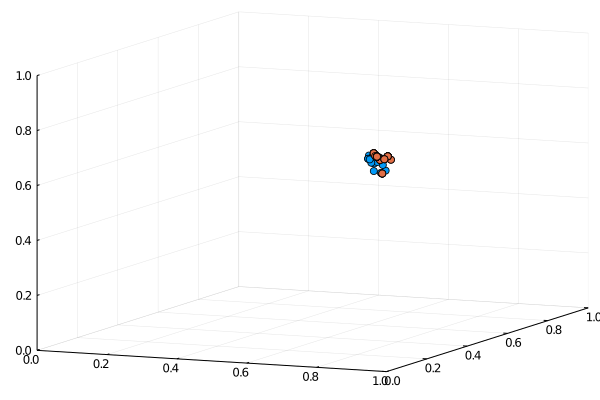

In [78]:
function plot_pop3D(P)
    scatter3d([i.y[1] for i in P], [i.y[2] for i in P],[i.y[3] for i in P], xlims=(0.0, 1.0), ylims=(0.0, 1.0), zlims=(0.0,1.0),legend=:none)
    ND = filter(indiv -> indiv.rank == 1, P)
    scatter3d!([i.y[1] for i in ND], [i.y[2] for i in ND],[i.y[3] for i in ND], legend=:none)
end

nsga_max(popsize, nbgen, objective, init, fCV=constraint, fplot=plot_pop3D, plotevery=1, showprogress=false);

Another way to look at the different objectives is to plot the different objectives on the `x` axis and the fitness values on the `y` axis. Each individual in a population is then represented as a line. Let's try this method, increasing the number of objectives to 10.

In [84]:
n = 100
n_objectives = 12
values = rand(n, n_objectives)
values = values ./ sum(values, dims=1)
weights = rand(n)
weights = weights ./ sum(weights)
max_weight = 0.5
popsize = 100
nbgen = 50
init() = bitrand(n)

init (generic function with 1 method)

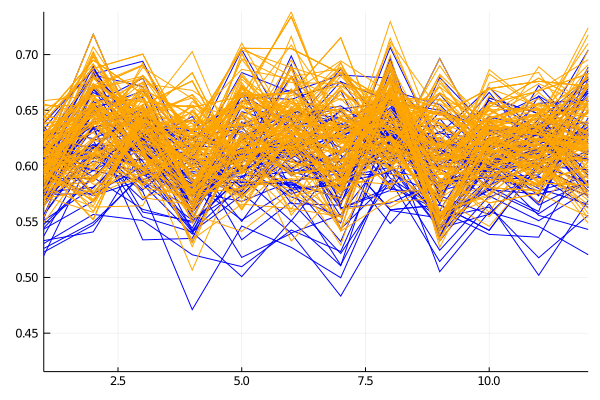

In [85]:
ymin = Inf
ymax = -Inf
function plot_pop(P)
    global ymin = min(ymin, minimum([minimum(i.y) for i in P]))
    global ymax = max(ymax, maximum([maximum(i.y) for i in P]))
    plot(xlims=(1, n_objectives), ylims=(ymin, ymax))
    ND = filter(indiv -> indiv.rank == 1, P)
    dominated = filter(indiv->indiv.rank != 1, P)
    for i in dominated
        plot!(1:n_objectives, collect(i.y), legend=:none, color=:blue)
    end
    for i in ND
        plot!(1:n_objectives, collect(i.y), legend=:none, color=:orange)
    end
    sleep(2.0)
end

non_dominated = nsga_max(popsize, 50, objective, init, fCV=constraint,
    fplot=plot_pop, plotevery=10, showprogress=false);

<div class="alert alert-success">
    <b>Exercise 4</b>
    <br/>
Gradually increase $K$, the number of objectives, and watch the number of non-dominated individuals in the population over evolution. What do you notice as $K$ increases?
    <br/>
</div>

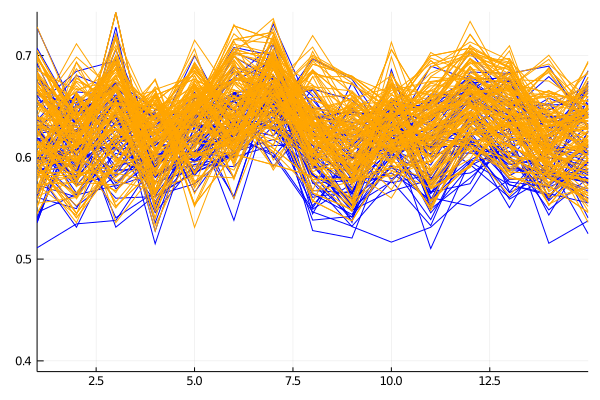

In [87]:
n_objectives = 15
values = rand(n, n_objectives)
values = values ./ sum(values, dims=1)
weights = rand(n)
weights = weights ./ sum(weights)
init() = bitrand(n)
non_dominated = nsga_max(popsize, 50, objective, init, fCV=constraint,
    fplot=plot_pop, plotevery=10, showprogress=false);

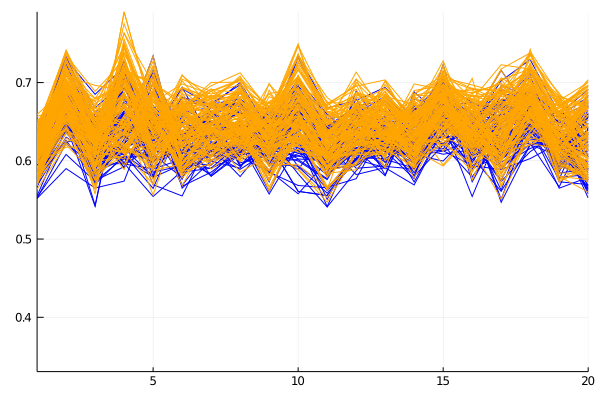

In [91]:
n_objectives = 20
values = rand(n, n_objectives)
values = values ./ sum(values, dims=1)
weights = rand(n)
weights = weights ./ sum(weights)
init() = bitrand(n)
non_dominated = nsga_max(popsize, 50, objective, init, fCV=constraint,
    fplot=plot_pop, plotevery=10, showprogress=false);

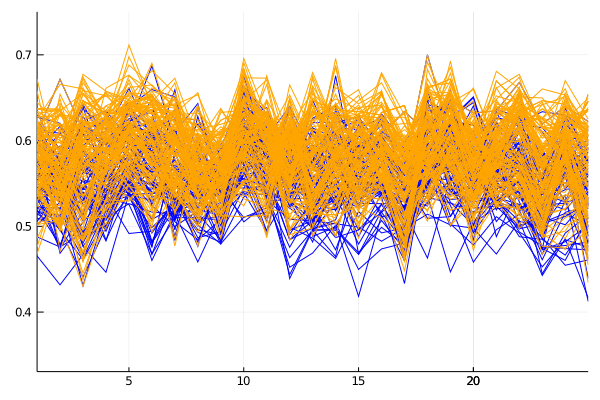

In [89]:
n_objectives = 25
values = rand(n, n_objectives)
values = values ./ sum(values, dims=1)
weights = rand(n)
weights = weights ./ sum(weights)
init() = bitrand(n)
non_dominated = nsga_max(popsize, 50, objective, init, fCV=constraint,
    fplot=plot_pop, plotevery=10, showprogress=false);

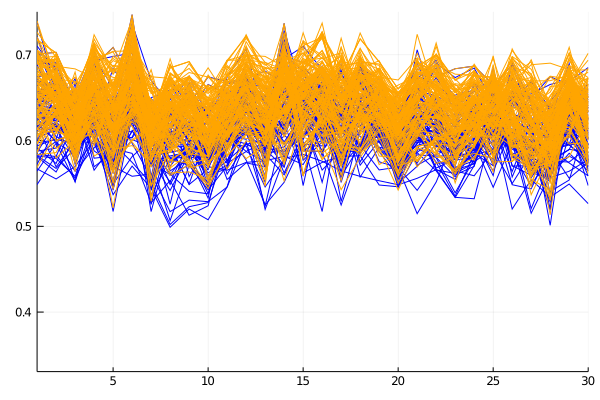

In [90]:
n_objectives = 30
values = rand(n, n_objectives)
values = values ./ sum(values, dims=1)
weights = rand(n)
weights = weights ./ sum(weights)
init() = bitrand(n)
non_dominated = nsga_max(popsize, 50, objective, init, fCV=constraint,
    fplot=plot_pop, plotevery=10, showprogress=false);

<div class="text-info bg-info">
    Il semble que le front de Paredo s'épaississent losqu'on augmente le nombre d'objectifs. Ce qui logique puisque la proportion de l'espace dominé devient de plus en plus faible.
</div>